# Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import PyTCI

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create filters gamma distributions
weights = []
for rate in [0.625, 1.25, 2.5, 5, 10, 20, 40]:
    dist = torch.distributions.gamma.Gamma(2, rate)
    dist = torch.tensor([torch.exp(dist.log_prob(i)) for i in np.arange(1e-4, 10, 0.005)])
    weights.append(dist.flip(0) / sum(dist))
weights = torch.stack(weights, dim=0).unsqueeze(dim=1).to(device).float()

# Create mock model that applies above filters to input
def model(x):
    x = torch.as_tensor(x, device=device)
    x = torch.nn.functional.pad(x, (0, 0, weights.shape[-1]-1, 0)).float()
    x = x.T.unsqueeze(dim=0)
    x = torch.nn.functional.conv1d(x, weights)
    x = x.squeeze(dim=0).T
    
    return x

# Estimate integration windows directly from filter windows
cdf = weights.squeeze(1).cumsum(axis=1).cpu()
intwin_cdf = [(np.where(c.flip(0) >= 0.10)[0][-1])/1000+0.001 for c in cdf]

# Create 1000 random 5-second segments with sampling rate of 1000
sr = 1000
segments = [torch.randn(5000, 1) for i in range(1000)]

# Basic usage

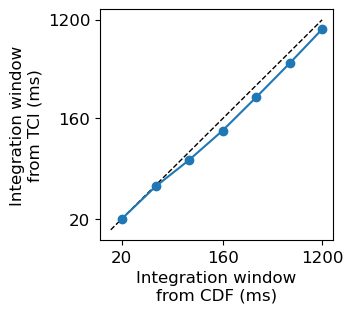

In [2]:
# Setup TCI analyzer
analyzer = PyTCI.Analyzer(out_sr=1000, model=model, threshold=0.95, verbose=False)

# Feed list of source segments to analyzer
analyzer.set_segments(segments, sr=1000)

# Estimate integration periods using TCI paradigm
intwin_tci = analyzer.estimate_integration_window()

# Compare results
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.016, 1.2]), np.log([0.016, 1.2]), 'k--', linewidth=1)
plt.plot(
    np.log(intwin_cdf),
    np.log(intwin_tci),
    '-o'
)
plt.xticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window\nfrom CDF (ms)', fontsize=12)
plt.ylabel('Integration window\nfrom TCI (ms)', fontsize=12)
plt.show()

# Load segments from files

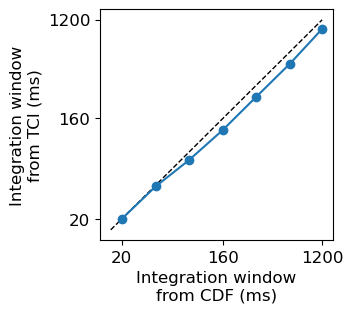

In [3]:
# Save segments to file
for i, segment in enumerate(segments):
    np.save(
        f'resources/segments/segment_{i:03d}.npy',
        np.array((segment.numpy(), sr), dtype=object)
    )

# Setup TCI analyzer
analyzer = PyTCI.Analyzer(out_sr=1000, model=model, threshold=0.95, verbose=False)

# Load source segments from disk
analyzer.load_segments('resources/segments/', fmt='numpy')

# Estimate integration periods using TCI paradigm
intwin_tci = analyzer.estimate_integration_window()

# Compare results
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.016, 1.2]), np.log([0.016, 1.2]), 'k--', linewidth=1)
plt.plot(
    np.log(intwin_cdf),
    np.log(intwin_tci),
    '-o'
)
plt.xticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window\nfrom CDF (ms)', fontsize=12)
plt.ylabel('Integration window\nfrom TCI (ms)', fontsize=12)
plt.show()

# Manual inference

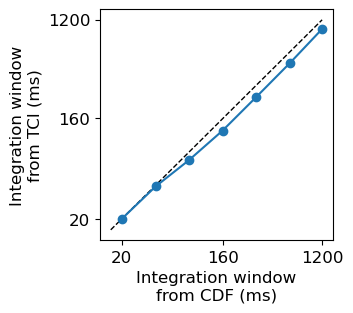

In [4]:
# Setup TCI analyzer
analyzer = PyTCI.Analyzer(out_sr=1000, threshold=0.95, verbose=False)

# Feed list of source segments to analyzer
analyzer.set_segments(segments, sr=1000)

# Generate two TCI sequences seq_A and seq_B and write them to disk
analyzer.write_sequences('outputs/manual-seq', fmt='numpy')

# Read sequences from disk, infer responses of the model, and write the two
# response sequences to disk
os.makedirs('outputs/manual-resp', exist_ok=True)
for segdur in analyzer.segment_durs:
    seq_A = np.load(f'outputs/manual-seq/seq_A_{round(segdur*1000)}ms.npy')
    resp_A = model(seq_A)
    np.save(f'outputs/manual-resp/resp_A_{round(segdur*1000)}ms.npy', resp_A.cpu())
    
    seq_B = np.load(f'outputs/manual-seq/seq_B_{round(segdur*1000)}ms.npy')
    resp_B = model(seq_B)
    np.save(f'outputs/manual-resp/resp_B_{round(segdur*1000)}ms.npy', resp_B.cpu())

# Read responses to both TCI sequences from disk
analyzer.read_responses('outputs/manual-resp', fmt='numpy')

# Estimate integration periods using TCI paradigm
intwin_tci = analyzer.estimate_integration_window()

# Compare results
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.016, 1.2]), np.log([0.016, 1.2]), 'k--', linewidth=1)
plt.plot(
    np.log(intwin_cdf),
    np.log(intwin_tci),
    '-o'
)
plt.xticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window\nfrom CDF (ms)', fontsize=12)
plt.ylabel('Integration window\nfrom TCI (ms)', fontsize=12)
plt.show()

# Preprocessing

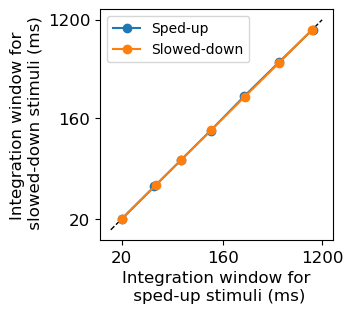

In [5]:
# Estimate integration periods for original inputs
analyzer = PyTCI.Analyzer(out_sr=1000, model=model, threshold=0.95, verbose=False)
analyzer.set_segments(
    segments, sr=1000
)
intwin_norm = analyzer.estimate_integration_window()

# Estimate integration periods for sped-up inputs
analyzer = PyTCI.Analyzer(out_sr=1000, model=model, threshold=0.95, verbose=False)
analyzer.set_segments(
    segments, sr=1000, preprocess=PyTCI.preprocessing.audio_speed_fx(scale_factor=1.2)
)
intwin_fast = analyzer.estimate_integration_window()

# Estimate integration periods for slowed-down inputs
analyzer = PyTCI.Analyzer(out_sr=1000, model=model, threshold=0.95, verbose=False)
analyzer.set_segments(
    segments, sr=1000, preprocess=PyTCI.preprocessing.audio_speed_fx(scale_factor=0.8)
)
intwin_slow = analyzer.estimate_integration_window()

# Compare results
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.016, 1.2]), np.log([0.016, 1.2]), 'k--', linewidth=1)
plt.plot(
    np.log(intwin_norm),
    np.log(intwin_fast),
    '-o', label='Sped-up'
)
plt.plot(
    np.log(intwin_slow),
    np.log(intwin_slow),
    '-o', label='Slowed-down'
)
plt.xticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.02, 0.16, 1.2]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window for\n sped-up stimuli (ms)', fontsize=12)
plt.ylabel('Integration window for\n slowed-down stimuli (ms)', fontsize=12)
plt.legend()
plt.show()